# Bayesian Hierarchical Linear Regression

<center><img width=60% src="https://memegenerator.net/img/instances/86111864.jpg"/></center>

Hello my Bayesian friends and welcome back to this final lesson on hierarchical regressions. This is where we really take things to the next level. You probably thought that just Bayesian regressions were already pretty cool, well Justin Timberlake is here to tell you that you ain't seen nothing yet. Indeed, before Justin joined the backstreet boys he dabbled in Bayesian statistics. And if you have a strong prior that that's not true, I think we did our job well so far with this course.

## Motivation
* Bayesian linear regressions are great, but not that novel
* Hierarchical models are:
  - Very widely applicable (nested data very common)
  - Uniquely Bayesian
  - Higher accuracy, especially with small data
* Doorway to seeing the full power and flexibility of Bayesian modeling

So why does Justin Timberlake think that hierarchical models are cooler than just linear ones? Up until now, we showed you the cool benefits of doing regressions in a Bayesian framework. However, it's also not *that* novel. Yes, we get better uncertainty than with frequentist statistics and can set priors, but we could not fundamentally do things we couldn't do without the Bayesian framework.

Well, this is about to change as hierarchical models are going to rock your world. This modeling structure is very powerful, widely applicable, and also very hard to do in other frameworks. So this is truly a super-power of the Bayesian approach. Most important of all, hierarchical models can improve the accuracy of your model, especially if you have few data points.

In addition, grocking the idea of hierarchical modeling is going to expand your mind to see the full potential and flexibility of Bayesian modeling. And if you think I'm hyping this up too much you're mistaken, these are the crown jewels right here. So strap in, lean back, and enjoy the ride.

## When Are Hierarchical Models Beneficial?
<br>
<center><img width=50% src="https://memegenerator.net/img/instances/86096861.jpg"/></center>

Whenever we have similarities between groups!

 * Species of fish
 * Users on a website
 * Marketing channels
 * Nested data
   - Multiple schools in the same district
   - Different brands of sneakers in an online store

So where are hierarchical models beneficial? Well I'm glad you asked! Basically whenever we assume that there similarities between groups of data. Like the fish data set from the last lesson which we will also explore further here. Another example might be if you are analyzing users comeing to your website on some metric. Likely they will share similarities. Or you are advertising on different marketing channels, like TV, podcasts and social media. They are all different but still will likely share certain similarities.

A data structure where hierarchical modeling is usually a good fit for is whenever you have nested data. This occurs naturally with geographical data where maybe you are analyzing multiple schools which are grouped into districts.

Another example would be an online store selling different brands of sneakers. The individual sneakers are naturally nested at the brand level.

So to summarize, whenever you have one or multiple groups in your data, hierarchical models can be a good choice. It is actually pretty baffling to me that despite this pattern being so common, only Bayesian modeling can exploit the full potential of this.

## Lesson Overview

* Why Hierarchical Regression

* Distributions Over Distributions

* Hierarchical Modeling in PyMC

* What Does the Hierarchy Actually Do?

Let's provide you with a little road map of how this lesson will be structured.

First, we will ask why we even need hierarchical regression. As you'll, see the pattern in our fish market data from the previous lesson is actually not modelled in a very satisfying way, as we are not capturing the similarities between parameters.

Next, we will see how we can build hierarchies by placing distributions over distributions. Here we will play around with some simulated data to build up our intuitions.

We are then ready for the most exciting part: how to code this model in PyMC. Don't be scared, it's actually quite simple.

And then finally, we will build intuitions around the effect of the hierarchy. Particularly, what happens to the individual estimates and how these are affected by how much data we have. We will learn, that hierarchical models provide a form of what I like to call *smart regularization*.

Are you ready? Then let's go! In the remainder of this section I want to provide the motivation for using hierarchical models by looking at our fish data set from the last lesson again.

To recap, in this section we went over a brief motivation for why hierarchical models are the super-power of Bayesian modeling. I then showed you what we'll cover in this lesson.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings
from IPython.display import Image

#import jupyter_black
#jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
#warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import warn, simplefilter
simplefilter('ignore')

# Why Hierarchical Regression
Make the most out of your data

OK, we just learned how amazing Bayesian regressions are, but we are going to take it one step further here.

## Let's look at the data again

In [2]:
fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()
fish_market

,Species,Weight,Length1,Height,Width,log_width,log_height,log_length,log_weight
0,Bream,242.0,23.2,11.5200,4.0200,1.391282,2.444085,3.144152,5.488938
1,Bream,290.0,24.0,12.4800,4.3056,1.459917,2.524127,3.178054,5.669881
2,Bream,340.0,23.9,12.3778,4.6961,1.546732,2.515905,3.173878,5.828946
3,Bream,363.0,26.3,12.7300,4.4555,1.494139,2.543961,3.269569,5.894403
4,Bream,430.0,26.5,12.4440,5.1340,1.635885,2.521239,3.277145,6.063785
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936,0.331890,0.737355,2.442347,2.501436
155,Smelt,13.4,11.7,2.4300,1.2690,0.238229,0.887891,2.459589,2.595255
156,Smelt,12.2,12.1,2.2770,1.2558,0.227773,0.822859,2.493205,2.501436
157,Smelt,19.7,13.2,2.8728,2.0672,0.726195,1.055287,2.580217,2.980619


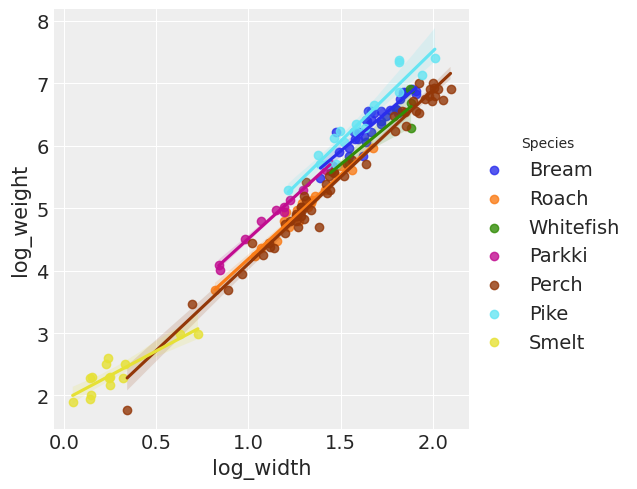

In [3]:
sns.lmplot(
    data=fish_reduced,
    x="log_width",
    y="log_weight",
    hue="Species",
);

Let's load in the fish data from the linear regression module and plot them again. This time, however, I'm plotting all fish and their regression lines in the same plot.

Remember from before that Alex first built a model that fit a single regression to all fish species and found that it's not a good fit. He then fit separate regressions, like we're doing in this plot, which produced a much better fit.

But looking at the data, what do you think of that choice? Notice anything?

Yes, exactly, while the fish species aren't identical, they are pretty damn similar.

## Between a Rock and a Hard Place

<center><img width=16% src="https://i.imgflip.com/661i2t.jpg"/></center>

1. Everything is identical
2. Everything is different and shares no similarities

We can clearly see that neither of these are true in this data.

So to summarize, either we assume all fish species are exactly the same, or a model that assumes they share no similarity at all. Neither of which are true: the correlation between width and weight between the different species are similar but not identical.

## Bayes to the rescue!

<center><img width=40% src="https://miro.medium.com/max/920/1*_i4uVp43apgOMpHRw6WG-w.jpeg"></center>

But fear not, for our dear Reverend comes to bust us out of this pickle once again and offer us a third way, which is what you'll learn about in this lesson, I hope you're excited!

In order to build intuitions for how we could model this, let's take a closer look at the similarities between the *parameters* of the different species in the model from the previous lesson.

# What Do The Similarities Look Like in Parameter Space?

To do that, let's run the unpooled model from the previous lesson on Bayesian linear regressions. 

Note, that to make the code simpler, we will now only consider a single predictor, rather than all three. The predictor we will use is the width, but it doesn't matter which one we pick.

In [4]:
fish_test = fish_reduced.sample(frac=0.1, random_state=RANDOM_SEED).sort_index()
test_idx = fish_test.index
fish_train = fish_reduced.loc[fish_reduced.index.difference(test_idx)]

species_idx, species = fish_train.Species.factorize(sort=True)
COORDS = {
    "slopes": ["width_effect"],  # , "height_effect", "length_effect"],
    "species": species,
}

COORDS

{'slopes': ['width_effect'],
 'species': Index(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'], dtype='object')}

## Unpooled Model

In [5]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_unpooled:
    # data
    log_width = pm.MutableData("log_width", 
                               fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", 
                                fish_train.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims=("species"))

    # linear regression
    mu = pm.Deterministic("mu", intercept[species_idx_] + \
                                β[species_idx_] * log_width)

    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


This is basically the same model you've seen in the last section, so I'm not going to go over it again.

Rather, let's look at the different intercept and beta parameters.

## Extract Posterior Means

In [6]:
df_plot = (
    idata_unpooled.posterior[["intercept", "β"]]
    .mean(("chain", "draw"))
    .to_dataframe()
    .rename_axis(columns="parameters")
    .stack()
    .reset_index()
    .rename(columns={0: "mean"})
)
df_plot

,species,parameters,mean
0,Bream,intercept,2.409052
1,Bream,β,2.344840
2,Parkki,intercept,2.425145
3,Parkki,β,2.140096
4,Perch,intercept,1.347200
5,Perch,β,2.772343
6,Pike,intercept,2.223119
7,Pike,β,2.582694
8,Roach,intercept,1.927898
9,Roach,β,2.357280


## Histogram Over Intercepts And Slopes

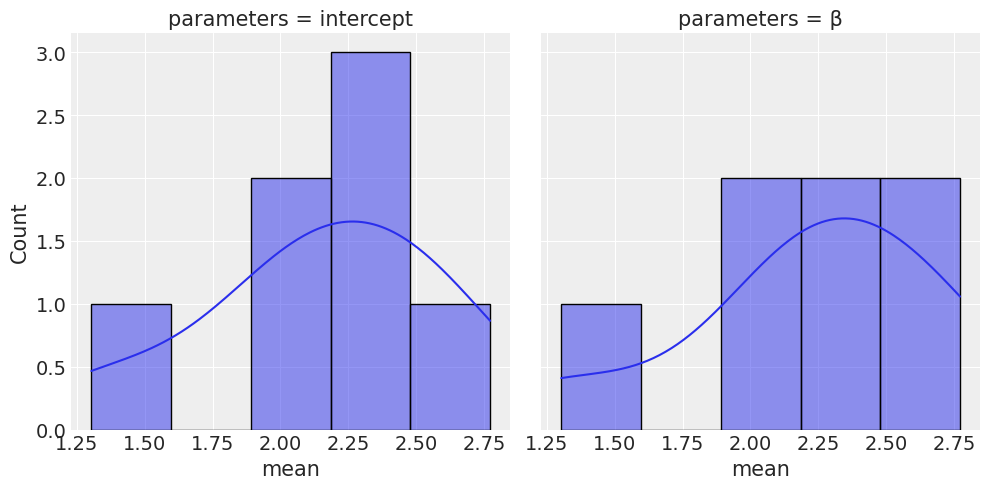

In [7]:
sns.displot(df_plot, x="mean", col="parameters", kde=True);

OK, what I did here was to extract the posterior means of each of the species' intercept and beta parameters.

I know it's just a couple of points, but what does that look like to you?

Well the first thing to note is that the estimates seem clustered around a common value, they are all very similar like we already saw from looking at the raw data.

Now, how would we model this? Exactly, like we always do: with a probability distribution!

The only thing we need to decide is which distribution we should use. While there are some options, as always, typically a normal distribution is used, just because its simple.

## Overview of the different approaches

To get a better idea of how this is different from the pooled and unpooled let's compare the approaches visually.

## Pooled

<center><img src="imgs/pooled_model-2.png"/></center>

First, the pooled model essentially looks like this. Here, we have one global parameter theta -- which is the symbol at the top. Theta can represent the intercept or slope parameter in our regression model while y_1 is a vector of all data points of the first fish species. As you can see, in the pooled model we have one global set across all fish species.

## Unpooled

<center><img src="imgs/unpooled_model-2.png"/></center>

In the unpooled case we have localized parameters for every species, they all have different intercepts and slopes. As you can see, no information is shared between the different species.

Now how does this picture change when we add a distribution over the individual thetas?

## Hierarchical

<center><img src="imgs/partial_pooled_model-2.png"/></center>

Boom! We add another layer *on top* of the thetas. The parameter mu represents the mean of the thetas, and sigma the standard deviation of that global distribution. So you can see how we're combining both approaches by taking the unpooled model but share similarities between them by linking them at the global level. That's also the reason why these models are sometimes called *partially pooled* models.

# Section Summary

* Run unpooled model from previous lesson
* Analyze posterior means of intercepts and slopes
* Idea: Model similarities with a **probability distribution**
* Add a global distribution to the unpooled model to get hierarchical model
* Next: How to *think* about distributions over distributions

To recap, in this amazing section we have rerun the unpooled model from the pervious lesson. We then extracted the posterior means of the intercepts and slopes and plotted a histogram over them.

We then noticed how the parameters seem to cluster and came up with the idea of placing a distribution over these parameters. By looking at some visualizations we have seen how we can turn the unpooled model into a hierarchical one by joining the separate parameters under a global distribution.

In the next section, we're gonna have even more fun by playing around with some distributions over parameters to get a feel for how these levels influence each other. Are you as excited as I am? That's great!

# Distributions Over Parameters
<br>

<center><img src="https://memegenerator.net/img/instances/86091597.jpg"/></center>

* Old: specify a distribution over data points 
* New: specify a distribution over **parameters**.

OK my Bayesian friend, it's time to go a level deeper in the dream that is Bayesian modeling. And I do mean deeper in every sense of the word. We will go deeper in our understanding of Bayesian modeling as well as get to see see how we can build deeper distributions by placing distributions on top of them.

The central idea here is that just like we can say that a set of data points is, for example, normally distributed, we can do the same for a group of parameters, in this case, the intercepts and slopes of the different fish.

This insight has far-reaching consequences and allows us to build highly complex and *deep* models.

# Generating Hierarchical Data

* Building intuition around distributions over parameters
* Simple generative process
* Effects of changing parameters

The goal of this section is to  simplify things down to build an intuition for how to think of distributions over parameters. We will do this with a code-first approach as is the motto of our course. For this, we will generate some data that follows what is happening in a hierarchical model and change parameters to see the effects that has.

## Setting Things Up

In [8]:
from scipy import stats

global_mu = 0
global_sigma = 0.5
local_sigma = 0.1
n_local = 8

global_dist = stats.norm(global_mu, global_sigma)

For this generative approach we will use the excellent `scipy.stats` submodule. Don't worry, it's fairly self-explanatory.

First, we define some parameters to use in our generative process. We set the global mean `global_mu` to 0 and the global standard-deviation `global_sigma` to 0.5. These are the parameters of our global distribution. `localsigma` is the standard deviation in our local distributions. Let's further assume that we have 8 local distributions guided by that global distribution. Don't worry, this will become more clear in a second.

Then in the next step, we instantiate a normal distribution from the `scipy.stats` package and give it the parameters for our global distribution.

## Generating Means for the Local Distributions

In [9]:
local_mus = global_dist.rvs(size=n_local)
local_mus

array([-0.27, -0.34, -0.62, -0.27,  0.07, -0.62, -0.27, -1.23])

Next, we generate 8 mus for our local distributions by calling the `rvs()` random sampling method of the global distribution.

#### Generating Data From Each Local Distribution

In [10]:
local_samples = []
# Iterate over individual bottom level mus
for local_mu in local_mus:
    # Draw 1000 samples from local distribution
    samples = stats.norm(local_mu, local_sigma).rvs(1000)
    # Save results
    local_samples.append(samples)

In this step we go through every local `mu` and generate samples for this local distribution using the standard-deviation of `.1` we defined above. Here I just sample `1000` values but that's arbitrary.

This concludes our data generative process that's behind hierarchical models. We have a global distribution that's guiding how the local distributions' parameters are distributed.

Let's next see how this looks graphically.

In [11]:
def gen_hier_plot(mu=0, sigma=0.5, eps=0.1, groups=8, seed=2):
    """
    Sample hierarchical data and plot it.
    """
    from scipy import stats
    from numpy.random import RandomState, SeedSequence, MT19937

    rs = RandomState(MT19937(SeedSequence(seed)))

    x = np.linspace(-3, 3, 1000)
    group_dist = stats.norm(mu, sigma)
    mus = group_dist.rvs(groups, random_state=rs)
    data = []
    for m in mus:
        data.append(stats.norm(m, eps).rvs(1000, random_state=rs))

    fig, axs = plt.subplots(nrows=2, sharex=True)
    pdf = group_dist.pdf(x)
    axs[0].plot(x, pdf)
    axs[0].set(title=f"global distribution\nmu={mu} sigma={sigma}", ylabel="belief")
    axs[1].set(title="local distributions", xlabel="x")
    for i, d in enumerate(data):
        axs[0].plot(mus[i], 0, ".", ms=8, color=sns.color_palette()[i])
        sns.histplot(data=d, ax=axs[1], color=sns.color_palette()[i])
        axs[1].axvline(mus[i], color=sns.color_palette()[i])

#### Global Distribution Constrains Local Distributions

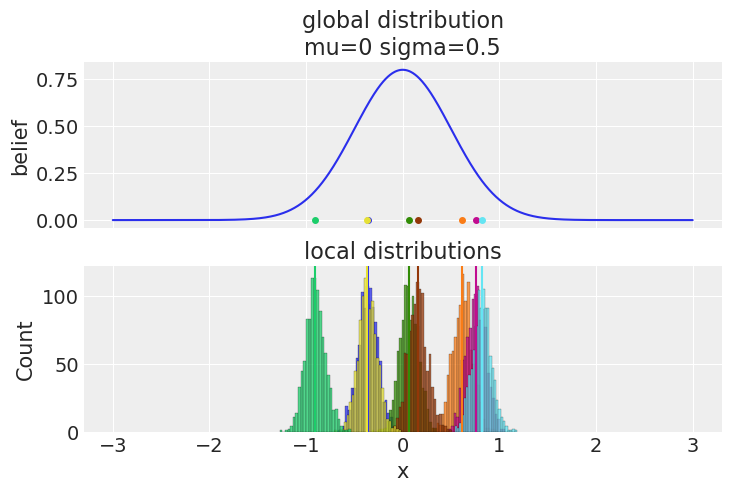

In [12]:
gen_hier_plot()

In the top plot you can see the global distribution in blue. From this distribution, we sample some points as you can see at the bottom of the top-plot in various colors. These are the means of the local distributions.

Then in the plot below we have the values we sampled for the local distributions. In the case of our hierarchical fish model, you can imagine that these are the posteriors of the intercepts, the posterior means of which are guided by the global distribution. Of course, in reality we would estimate the parameters of the global distribution as well, here I just fixed them for illustrative purposes.

#### Global Standard Deviation Controls Dispersion of Means of Local Distributions

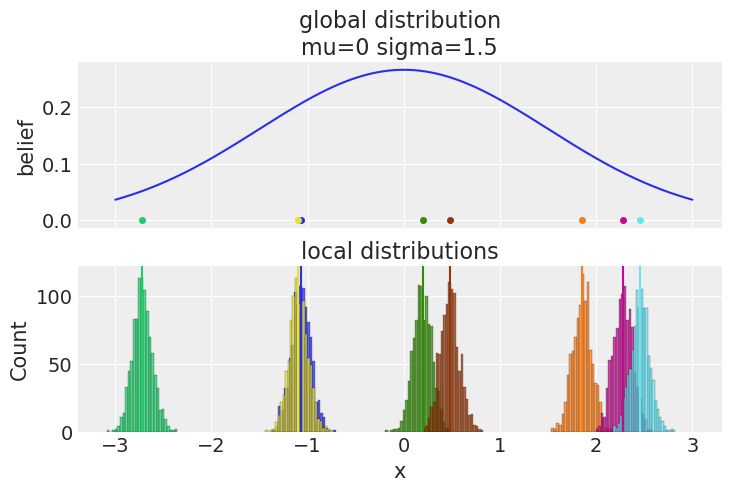

In [13]:
gen_hier_plot(sigma=1.5)

Now what happens when we change the standard-deviation of the global distribution? Well, the means of the local distributions become more scattered and move further away from the mean of the global distribution. Said another way, the influence of the global distribution on the local distributions is weaker and we see less shrinkage.

If we would increase the standard-deviation even more we actually get no influence from the global distribution whatsoever. Does that remind you of anything? Yes, that's exactly what's happening in unpooled models. So the hierarchical model approaches the unpooled model as we increase the standard-deviation.

#### global Mean Shifts the local Distributions

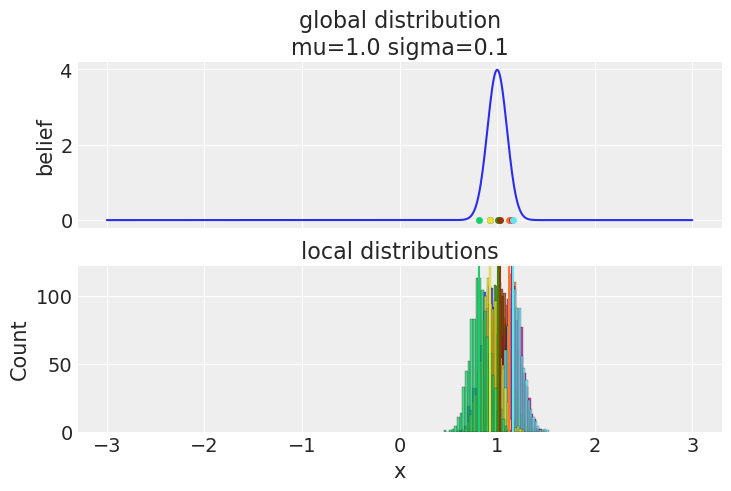

In [14]:
gen_hier_plot(mu=1.0, sigma=0.1)

Now what happens when we move the mean and make standard-deviation of the global distribution really small? Well, now the local distributions are all tightly clustered around the global mean. Here we would say that there is strong shrinkage towards the global mean. What would happen if we decreased the standard-deviation even more? Exactly, they would all become identical, just like in a pooled model. So you can see how the hierarchical model can scale between the pooled and unpooled one. Pretty neat insight, right?

And as a final point, as you can see, the mean shifts the local distributions while the standard-deviation controls the shrinkage, or, how much regularization is provided. With small standard-deviation our local estimates are not allowed to deviate far. The larger the standard-deviation, the weaker the influence of the global distribution.

## Section Summary

* Intuition of how to think about distributions over parameters
* Simple generative process
* global standard-deviation controls dispersion around global mean:
  - High standard-deviation: weak shrinkage ➞ approaches unpooled
  - Low standard-deviation: strong shrinkage ➞ approaches pooled
* global mean controls offset

Alright, so to wrap up, in this section we built some intuitions around distributions over distributions using a simple generative process. 

By looking at how the global distributions affects the local distributions we could see how changing the standard-deviation of the global distribution controlled the dispersion of the local distributions. 

If the standard-deviation is low, the local distributions are closely clustered around the global mean, so this provides strong shrinkage.

If the standard-deviation is high, the local distributions can move far away from the global mean, so there is a weak effect of the hierarchy, or weak shrinkage.

Finally, moving the global mean just shifts all the local distributions, that point is more straight-forward.

I hope that made sense, in the next section we will see how we can replicate this generative process in PyMC to estimate the parameters that we just fixed here.

# Hierarchical Models In PyMC

* How to code a hierarchical linear regression model

<center><img src="https://media4.giphy.com/media/7pLv68ItwBaHS/giphy.gif"/></center>

Alright, welcome back! I'm super excited about this section because here we're really getting to the good stuff. Rather than talk about intuitions, you're finally going to learn how to actually code hierarchical models in PyMC!

### Setting up the data containers

In [15]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as fish_hierarchical:
    # data
    log_width = pm.MutableData("log_width", 
                               fish_train.log_width.values)
    log_weight = pm.MutableData("log_weight", 
                                fish_train.log_weight.values)
    species_idx_ = pm.MutableData("species_idx", species_idx)

This should look very familiar, we just define our data containers and make them mutable so that you can replace their values in the homework.

## Intercept Hierarchical Model

In [16]:
with fish_hierarchical:
    # global priors for intercepts
    intercept_mu = pm.Normal("intercept_mu", sigma=3.0)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=1.0)

    # individual intercepts for each species
    intercept = pm.Normal(
        "intercept", mu=intercept_mu, sigma=intercept_sigma, 
        dims="species"
    )

Here is finally where things get interesting. Let's start at the bottom. We can again have our intercept parameters across the species dimension. However, instead of setting mu and sigma to fixed values as before, we now replace those with other parameters we are also going to estimate. That's the hierarchy in action.

Looking at the lines above, this is where we specify the priors for the mean and standard deviation of the species intercepts. From looking at the esimates from the unpooled model we know that the intercepts can deviate quite far from zero, so I chose a standard deviation of 3 for the intercept mean. And for the sigma parameter I pick a HalfNormal, because standard devations can only be positive. I pick a smaller `sigma` of 1 because the intercepts in the unpooled model were all pretty close together.

Of course, when creating this model using the full Bayesian workflow as you've seen in the previous lesson, we would run prior predictive checks to determine these values.

## Slopes for Hierarchical Model

In [17]:
with fish_hierarchical:
    # global prior for betas
    β_mu = pm.Normal("β_mu", sigma=3.0)
    β_sigma = pm.HalfNormal("β_sigma", sigma=1.0)

    # individual betas for each species
    β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims="species")

Next, we do the same for the betas. You can just imagine that the individual betas are data points we have observed and we want to estimate their mean and standard deviation. Of course, we also estimate the individual betas here, and they will get estimated together with their mu and sigma parameters together.

And you might be wondering right now, don't the individual beta estimates depend on the mu and sigma estimates? And don't the mu and sigma estimates in turn depend on the individual beta estimates? Yes, indeed, but it's not a problem for our powerful sampling algorithm which just figures this whole thing out for us.

## Linear Regression

In [18]:
with fish_hierarchical:
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

Now everything else in the model is exactly as before, we define our regression estimate.

## Likelihood and Error Term

In [19]:
with fish_hierarchical:
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )

And then we define our likelihood function after defining our error term.

## Model Structure

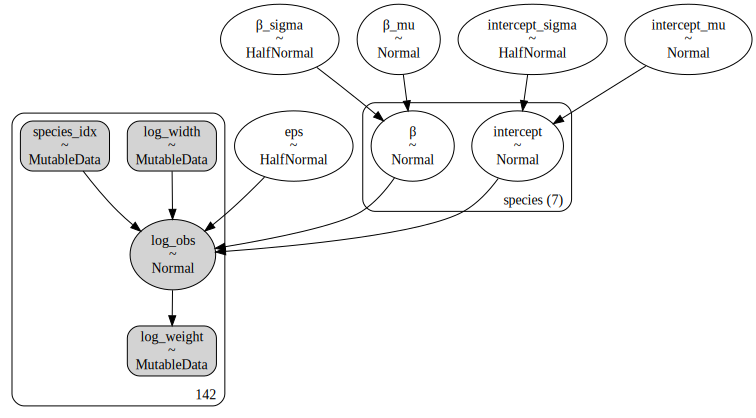

In [20]:
pm.model_to_graphviz(fish_hierarchical)

Looking at the model overview we can see that the betas and intercepts now have their own global parameters.

## Hitting the Inference Button (TM)

In [21]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


And now my usual favorite part: no math! We just hit our inference button and are on our way.

However, sometimes things do not go quite so smoothly, as we get informed about a divergence. This is a certain combination of plausible values the sampler is having difficulties with. If there are just a handful of divergences, say less than 5 it's usually nothing to worry about, but I wanted to show you how we can sometimes just improve the situation by increasing the `target_accept` parameter.

#### Increasing `target_accept` to Get Rid of Divergences

In [22]:
with fish_hierarchical:
    # Hit the Inference Button(TM)
    idata_hierarchical = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, β, eps]


/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b5/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


As you can see, setting `target_accept` to `0.95` gets rid of the divergence. Under the hood, this causes the sampler to explore the posterior more carefully at the cost of speed. You can usually start with setting it first to `0.85`, then `0.9`, then `0.95` and finally to `0.99`. 

If that does not help, probably your model is wrong, or you have bad data.

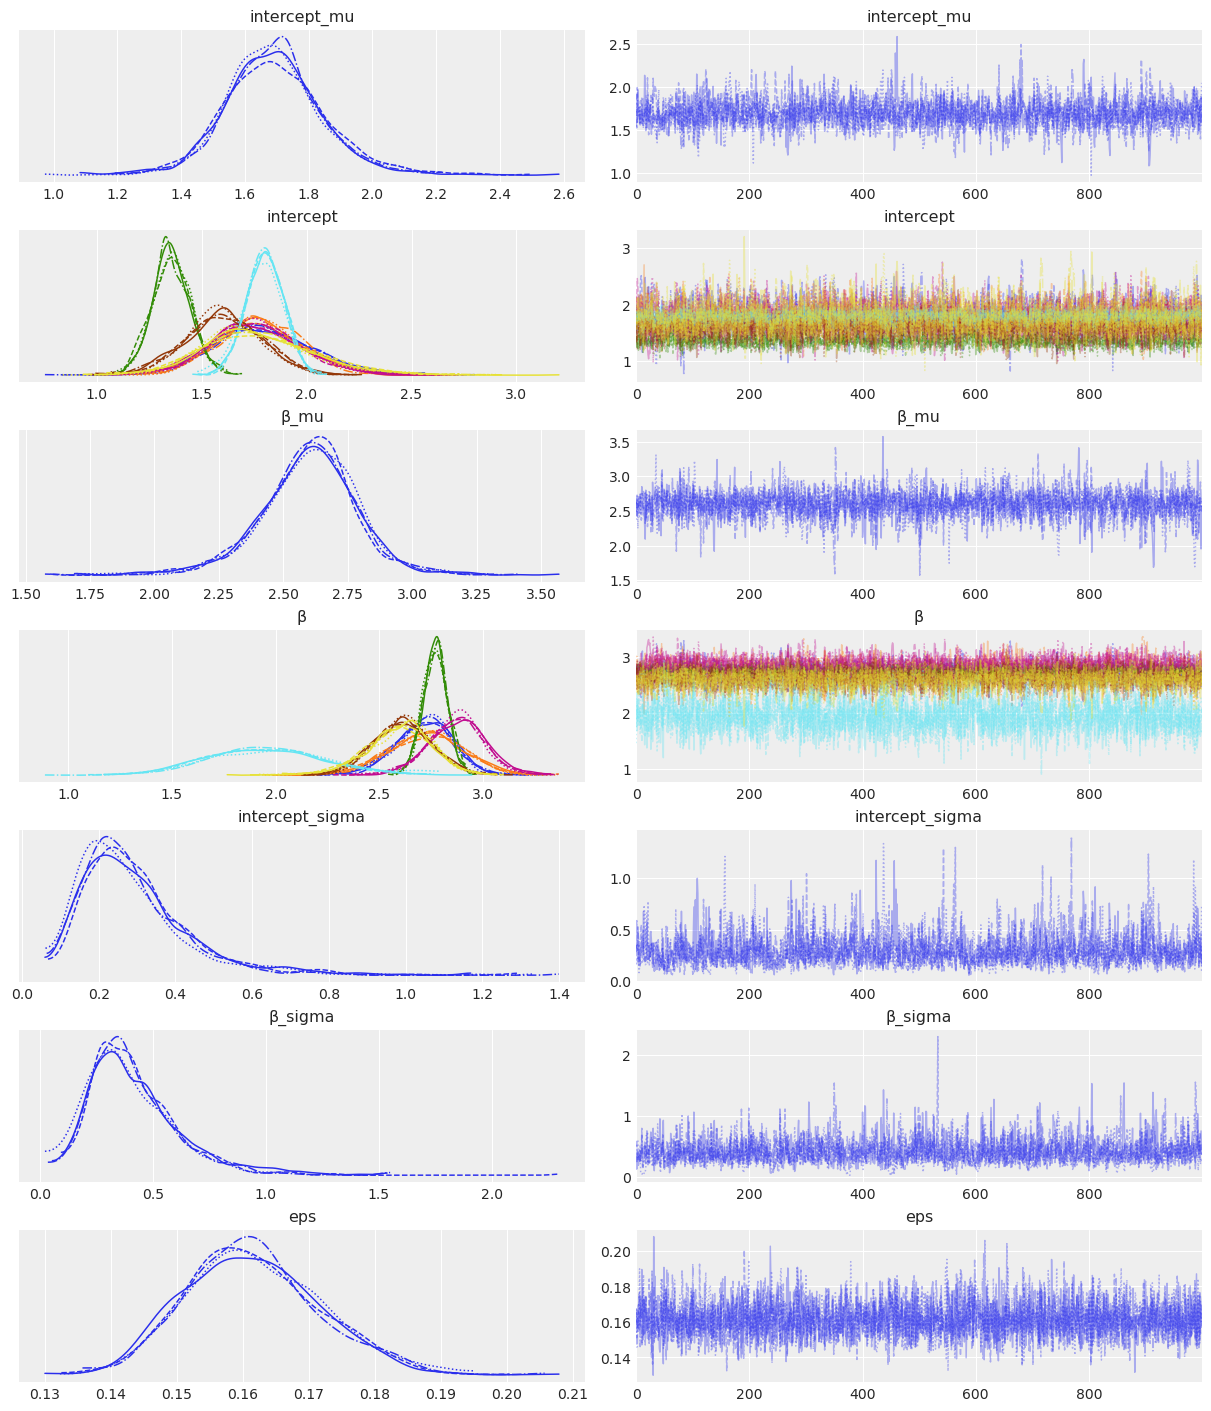

In [23]:
az.plot_trace(idata_hierarchical);

Here our posterior chains all look good -- nice!

## Section Summary

* Instead of `pm.Normal("x", 0, 1, dims="d")` ➞ `pm.Normal("x", mu, sigma, dims="d")`
* Divergences suggest there may be problems with the model or the data
* Increase `target_accept` to get rid of small number of divergences

Alright, in this section we've seen how instead of having a vector of Normal variables centered around a fixed value, we can also *estimate* the global mean and standard deviations by adding parameters with their own priors on them.

What's cool is that the rest of the model as well as the inference stayed the same, this is the power of the modular Lego approach of Bayesian modeling where we can iteratively add structure to our models to improve them.

However, this model is more complex to sample from and our sampler had some issues. This should cause us to take a look at the model if something is wrong, but if it's just a small number of divergences and there are no other red flags, we can usually just make the sampler go slower by increasing `target_accept`.

### What Does the Hierarchy Actually Do?

<center><img width=35% src="http://www.quickmeme.com/img/3d/3da2c0292c184996988b19d97e85548c79b5244726f1e8ed9650dacec2b48728.jpg"/></center>

* Concept of "smart priors"
* Effects on regression lines and posteriors
* What happens to estimate with many and few data points
* Concept of "smart regularization"

In this section we will take a look at what introducing the hierarchy into our model actually *does*. We will look at it through different lenses. First, I will introduce the concept of smart priors. Next, we'll look at what effect this has on the regression lines and on the actual posteriors.

This builds up our intutions around why hierarchies are so cool and how they are affected by the number of data points per group. This will then lead us to the concept of "smart regularization".

In [24]:
def plot_pred(idata, species="Whitefish", color="0.5", label="", ax=None):
    """
    Helper function to plot regression lines from the posterior on top of data points.
    """
    fish_spec = fish_reduced[fish_reduced.Species == species]
    x_lower = fish_spec["log_width"].min() - 0.5
    x_upper = fish_spec["log_width"].max() + 0.5
    x = np.linspace(x_lower, x_upper, 150)

    ys = []
    if ax is None:
        fig, ax = plt.subplots()
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color="k")

    y = idata.posterior["intercept"].sel(species=species).mean(
        ("chain", "draw")
    ).data + (
        x * idata.posterior["β"].sel(species=species).mean(("chain", "draw")).data
    )
    ax.plot(x, y, color=color, alpha=0.8, lw=3, label=label)

    for count, i in enumerate(range(100, 150)):
        y = idata.posterior["intercept"].sel(species=species, chain=0, draw=i).data + (
            x * idata.posterior["β"].sel(species=species, chain=0, draw=i).data
        )
        ys.append(y)
        ax.plot(x, y, color=color, alpha=0.1)

    ax.set(
        xlabel="log_width", ylabel="log_weight", title=f"Regression lines for {species}"
    )

    if label != "":
        ax.legend()

    return ax

### How Much Data Do We Have for Every Species?

In [25]:
fish_reduced.groupby("Species").count()["Weight"].sort_values()

Species
Whitefish     6
Parkki       11
Smelt        14
Pike         17
Roach        19
Bream        35
Perch        56
Name: Weight, dtype: int64

First, let's note something about the data set we've been working with. As you can see from the counts, for some fish, like Perch, we have many measurements, while for others, like Whitefish we only have a few data points.

Hierarchical models have a specific effect depending on how much data we have per group, so in this section we will look at what the hierarchical model does to the extreme cases of Whitefish and Perch.

### "Smart Priors"

* Unpooled: `β = pm.Normal("β", mu=0, sigma=1, dims="species")`
* Hierarchical: `β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims="species")`

Both provide *regularization*, one to `0` in a fixed way, the other to the **global mean** in a dynamic, data-dependent way. We **learn** the prior.

Looking at the code between the unpooled and hierarchical model side-by-side we see more clearly how they differ. In both cases we have a beta parameter with a normal prior for every species. But in the unpooled we set fixed values for `mu` and `sigma`. However, in the hierarchical model we replace the fixed values with global parameters we now estimate as well. In both cases, the prior provides regularization. In the case of unpooled towards zero while in the case of hierarchical towards the global mean. The standard-deviation of the prior `sigma` can be interpreted as how strong we want the regularization to be. Note that in the case of the hierarchical model we also learn this from the data. That's why I like to refer to this hierarchical structure as *smart priors*.

Let's look at this further to build our intuitions.

## Regression Lines Unpooled Model

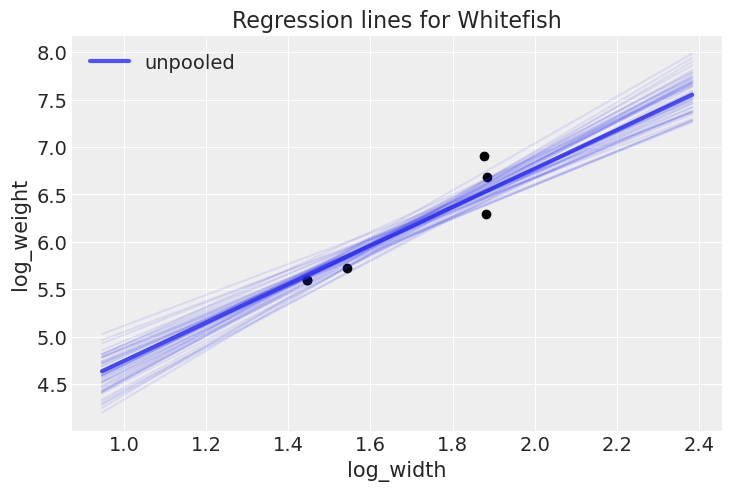

In [26]:
plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0]);

Here we see the regression lines for the unpooled model. The thick line is the mean while the lighter lines are individual draws from the posterior to give a sense of uncertainty. 

As you can see, we do not have a lot of data for Whitefish so our uncertainty is quite high: many regression lines could explain this data reasonably well.

Let's look at what happens in the hierarchical model.

## Regression Lines Hierarchical Model

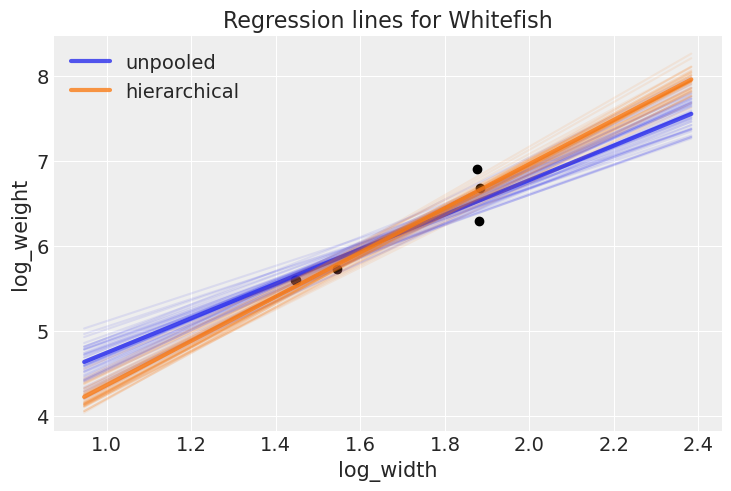

In [27]:
ax = plot_pred(idata_unpooled, label="unpooled", color=sns.color_palette()[0])
plot_pred(idata_hierarchical, label="hierarchical", color=sns.color_palette()[1], ax=ax);

Interesting, the line definitely changed. What are the two obvious changes?

Exactly, the intercept and slopes are both different, but also, the *uncertainty* is lower indicated by the lines being narrower around the mean.

Why is that happening? Let's look at the posteriors next to see what's going on.

## Posterior Unpooled vs Hierarchical

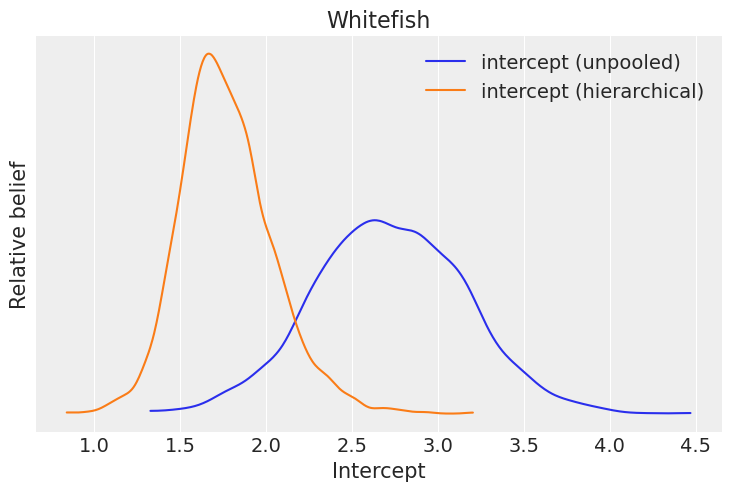

In [39]:
fig = az.plot_dist(
    idata_unpooled.posterior.intercept.sel(species="Whitefish"),
    color=sns.color_palette()[0],
    label="intercept (unpooled)",
)
az.plot_dist(
    idata_hierarchical.posterior.intercept.sel(species="Whitefish"),
    color=sns.color_palette()[1],
    label="intercept (hierarchical)",
)
plt.xlabel("Intercept")
plt.title("Whitefish");
plt.ylabel("Relative belief")
fig.axes.get_yaxis().set_ticks([]);

Let's compare the posteriors between the two models. 

1. The intercept posterior of the unpooled model;
2. The intercept posterior of the hierarchical model.

What do you see?

One thing we notice is that indeed the uncertainty of the hierarchical intercept is lower than that of the unpooled model, which mirrors what we've seen on the previous plot. It's also estimated lower. But why is that the case? Where is that increased certainty and the lower estimate coming from?

## Regularization Towards the Mean

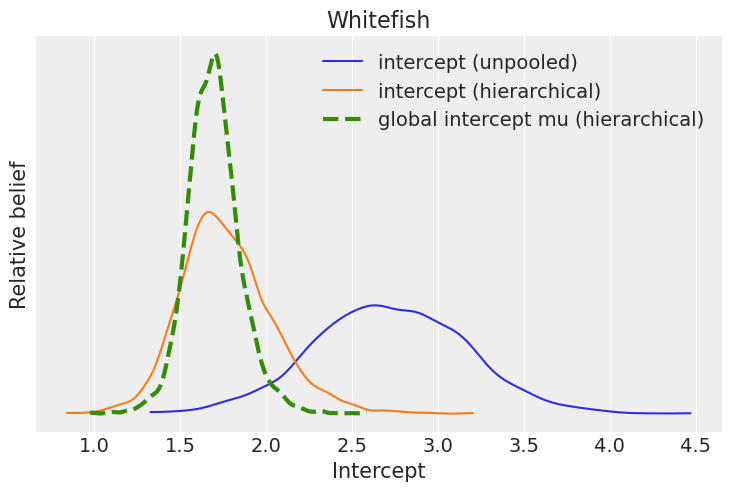

In [41]:
fig = az.plot_dist(
    idata_unpooled.posterior.intercept.sel(species="Whitefish"),
    color=sns.color_palette()[0],
    label="intercept (unpooled)",
)
az.plot_dist(
    idata_hierarchical.posterior.intercept.sel(species="Whitefish"),
    color=sns.color_palette()[1],
    label="intercept (hierarchical)",
)
az.plot_dist(
    idata_hierarchical.posterior.intercept_mu,
    color=sns.color_palette()[2],
    plot_kwargs=dict(ls="--", lw=3.0),
    label="global intercept mu (hierarchical)",
)
plt.xlabel("Intercept")
plt.title("Whitefish");
plt.ylabel("Relative belief")
fig.axes.get_yaxis().set_ticks([]);

Exactly! It's being pulled down by the mean, as you can see now that I add the global mu parameter of the hierarchical model.

Also, note that having the global mean estimate is useful in itself. In the unpooled model we did not have direct access to the global mean.

## Beta (Slope) Posteriors

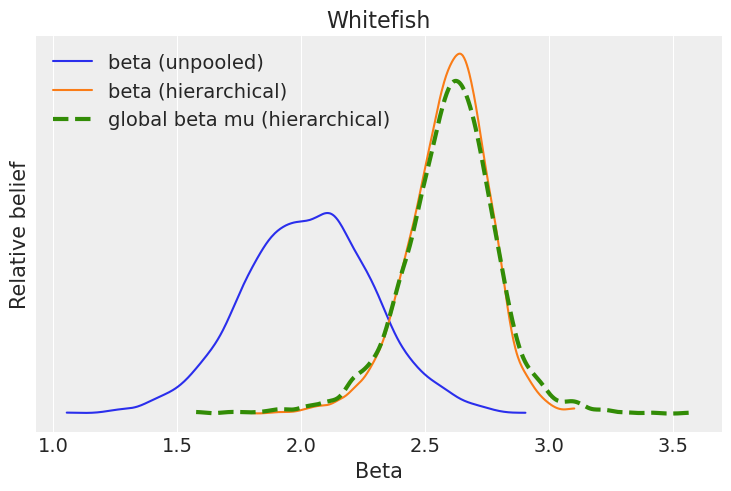

In [42]:
fig = az.plot_dist(
    idata_unpooled.posterior.β.sel(species="Whitefish"),
    color=sns.color_palette()[0],
    label="beta (unpooled)",
)
az.plot_dist(
    idata_hierarchical.posterior.β.sel(species="Whitefish"),
    color=sns.color_palette()[1],
    label="beta (hierarchical)",
)
az.plot_dist(
    idata_hierarchical.posterior.β_mu,
    color=sns.color_palette()[2],
    plot_kwargs=dict(ls="--", lw=3.0),
    label="global beta mu (hierarchical)",
)
plt.xlabel("Beta")
plt.title("Whitefish");
plt.ylabel("Relative belief")
fig.axes.get_yaxis().set_ticks([]);

And looking at the beta parameter posteriors we see the same pattern.

## Let's Look at Perch

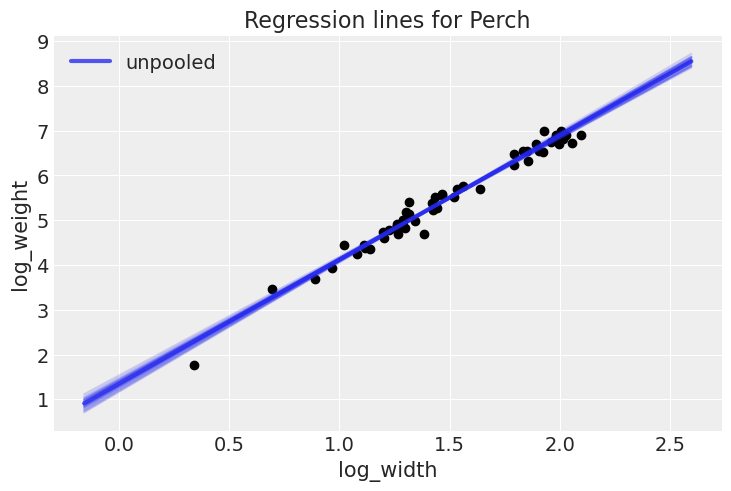

In [31]:
plot_pred(
    idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled"
);

OK, here we can see that there are many more data points and even the unpooled model is pretty certain about plausible regression lines.

Let's look at what the hierchical model says.

## Hierarchical and Unpooled side by side

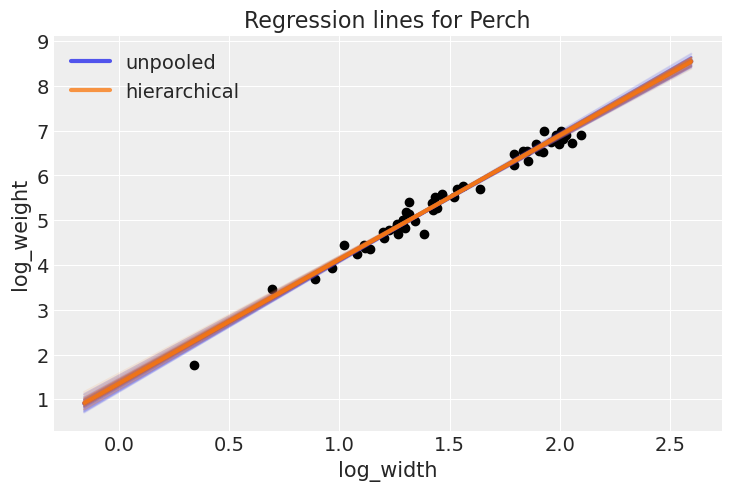

In [32]:
ax = plot_pred(
    idata_unpooled, species="Perch", color=sns.color_palette()[0], label="unpooled"
)
plot_pred(
    idata_hierarchical,
    species="Perch",
    color=sns.color_palette()[1],
    label="hierarchical",
    ax=ax,
);

Interesting, right? The two are almost identical. So it seems like the hierarchy does not have a big influence on the regression for Perch. Let's look next at the posteriors.

## And Now for the Posteriors...

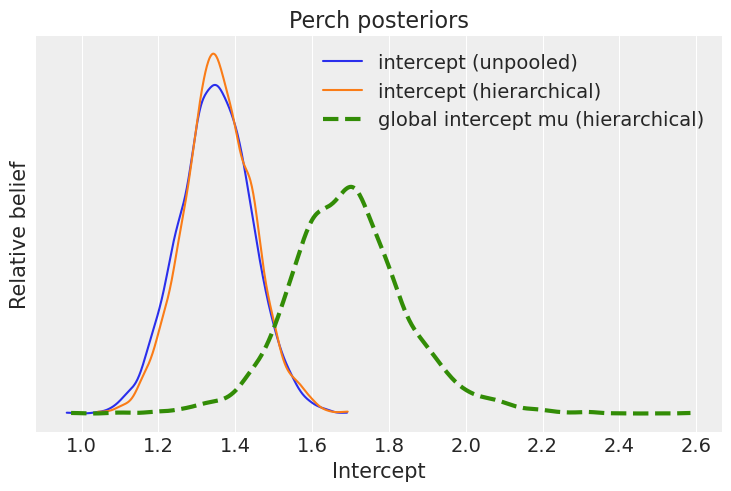

In [43]:
fig = az.plot_dist(
    idata_unpooled.posterior.intercept.sel(species="Perch"),
    color=sns.color_palette()[0],
    label="intercept (unpooled)",
)
az.plot_dist(
    idata_hierarchical.posterior.intercept.sel(species="Perch"),
    color=sns.color_palette()[1],
    label="intercept (hierarchical)",
)
az.plot_dist(
    idata_hierarchical.posterior.intercept_mu,
    plot_kwargs=dict(ls="--", lw=3.0),
    color=sns.color_palette()[2],
    label="global intercept mu (hierarchical)",
)
plt.xlabel("Intercept")
plt.title("Perch posteriors");
plt.ylabel("Relative belief")
fig.axes.get_yaxis().set_ticks([]);

What do you see here? What's different compared to the posteriors for Whitefish?

Yes, the posteriors for the unpooled and hierarchical model are almost identical, the global parameter mu has almost no influence. 

## And for The Beta Parameters...

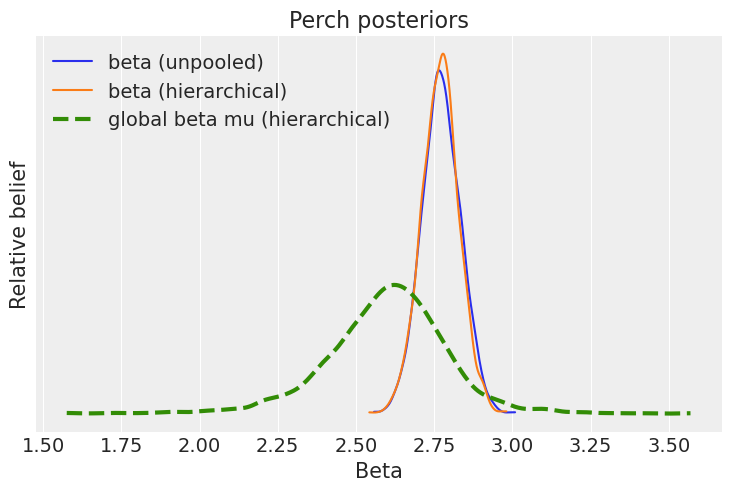

In [44]:
fig = az.plot_dist(
    idata_unpooled.posterior.β.sel(species="Perch"),
    color=sns.color_palette()[0],
    label="beta (unpooled)",
)
az.plot_dist(
    idata_hierarchical.posterior.β.sel(species="Perch"),
    color=sns.color_palette()[1],
    label="beta (hierarchical)",
)
az.plot_dist(
    idata_hierarchical.posterior.β_mu,
    plot_kwargs=dict(ls="--", lw=3.0),
    color=sns.color_palette()[2],
    label="global beta mu (hierarchical)",
)
plt.xlabel("Beta")
plt.title("Perch posteriors")
plt.ylabel("Relative belief")
fig.axes.get_yaxis().set_ticks([]);

Looking at the posteriors for beta we see the same pattern.

## Section Summary

* Shrinkage towards the mean
* Global estimate ⟷ individual estimates
* Few data points ➞ strong shrinkage
* Many data points ➞ weak shrinkage
* ➞ Smart regularization

So to summarize, in this section we looked at what effect the hierarchy has on the model estimates, compared to the unpooled model that shares no information between different fish. What the hierarchy does is estimate a mean and standard-deviation of how the  intercepts and betas of the different fish species are distributed. These resulting "smart priors" that are learned from data then have a regularizing effect on the individual estimates: just like regular priors they provide *shrinkage*. Shrinkage is basically regularization and means that when do not have enough data to say otherwise, we *shrink* our estimates towards a certain value, in this case we shrink towards the group mean. 

So you can see how they constrain each other: the individual betas are used to estimate the group parameters, while the group parameters are used to constrain the individual betas. And our Bayesian framework is smart enough to figure out exactly the ideal interplay between them.

But you've also seen that this shrinkage towards the mean does not happen statically. In the case of few data points like for Whitefish we saw a strong shrinkage effect, while in the case where we had many data points like for Perch the group distribution had almost no effect. That's why I called this here "smart regularization".

It is worth noting that nothing magical is going on here either. As I mentioned before, we can think of the hierarchy as "smart priors". And just like with regular priors, the prior is easily overwhelmed by data, and in the case of Perch we have enough data to overwhelm our "smart prior".

# Becoming a Bayesian Ninja
<br>
<center><img width=50% src="imgs/ninja.png"/></center>

OK, in this last section I want to perform the final step of our inception where we are diving deeper than one layer into our modeling. This hierarchical linear regression is really cool, right? I hope while going through this you already had ideas of where you can apply this to your own problems.

However, we are not constrained to just this particular pattern. We can place hierarchies in all kinds of models, not just regressions. If you run multiple AB tests for example, you can put those into a hierarchy.

In this section I want to make the point that we are actually not constrained to just this particular pattern of hierarchical regressions. We can place hierarchies in all kinds of models, not just regressions. If you run multiple AB tests, for example, you can model those with a hierarchy as well, no regressions invovled. And these are really the final insights that you need to become the Bayesian ninja that you're meant to be.

## Hierarchical Media Mix Model

<center><img width=65% src="imgs/mmm.png"/></center>

Or coming back to Bayesian Media Mix Model I showed you briefly at the very beginning of this course. 

In this model we're trying to estimate the effectiveness of different media channels on certain outcome variables, like how many new users we've gotten. As you might imagine, marketing channels definitely share similarities in how they function, so it makes sense to model this with a hierarchy. 

## Hierarchical Time-Series

<center><img width=60% src="imgs/HGP.png"/></center>

But we can even take this one step further. You might imagine that the ad-channel effectiveness is varying over time. For example, during COVID we definitely expect differences in how well our marketing is working. We can easily extend our Media Mix Model by placing a time-varying process over every marketing effectiveness parameter. But as noted on the previous slide, we expect these changes over time to also share similarities. Probably COVID will have impacted all our ad channels in a similar way, so we can turn this into a hierarchical time-series model as you can see in the graphic.

Your head might be spinning now as this is all starting to get very complex, right? But that's sort-of the point I'm trying to make. These models and hierarchies can become very complex and powerful, but nonetheless, with PyMC we can still fit these large-scale models. In fact, this is exactly the type of model we have built at PyMC Labs for HelloFresh, the multi-million dollar food delivery company.

## Plugging Parameters Into Parameters

<table><tr>
<td><img width=100% src="https://parenthesis-info.org/wp-content/uploads/2019/05/Traditional_Russian_Matryoshka.jpg"></td>
<td><img width=100% src="https://1.bp.blogspot.com/-wiuOhBdx6Ug/V0IpKOUiSpI/AAAAAAAAfYc/fnXs_qvt64sRAZTqdoRFL294Q8Q86XtogCLcB/s1600/russian-doll-train-ticket.jpg"/></td>
    </tr>
</table>
    

But hierarchies are just one pattern. Really the key insight is that we can input parameters into other parameters and build insanely complex models this way. This Russian doll approach also plays a big role when we think about generative modeling.

<center><img width=90% src="imgs/covid19_model.png"/></center>

Remember this slide from the introduction? There we made heavy use of this principle of plugging parameters into other parameters to model the generative process. In this case, we started with one person that was infecting a certain number of other people. Then those that are infected have a certain incubation period, as well as an additional delay to when they developed symptoms.

And then finally get a test that shows up in our dataset. That's the only thing we observe is the very end of that process. And at every step of that chain, we plug parameters into other parameters and then can use inference to reason backwards from the observed data to the latent causes of where one person infected a certain number of other people, which is the effect of reproduction rate that we were interested originally.

## Summary

* Pooled and unpooled models unsatisfactory

* Place parameters over parameters to build hierarchical models

* Provides smart regularization around global mean

* Regularization strength depends on group size

* Stacking parameters allows for great model flexibility

* We can more accurately model business problems

* Higher accuracy ➞ higher revenue

Alright, so let's summarize what we have learnt in this lesson. We started our journey with the insight that neither the pooled nor the unpooled model you've learned about in the previous lesson provide the right structure for modeling the correlations in our fish dataset.

We then saw how we can place parameters over parameters to build hierarchical models which provide the best of both worlds.

This hierarchy can be thought of as providing smart regularization around a global mean that we also estimate. 

And what's also cool is that the the strenght of that regularization depends on how much data we have for a group.

And in this last section I told you how this idea of stacking parameters allows us to build crazy complex models.

But of course we're not just building complex models for its own sake. But Bayesian modeling gives us a tool with which we can more accurately model business problems.

And of course, more accurate models mean higher revenue. So these tools can be incredibly impactful if employed in the right way.

# PyMCheers and Keep On Sampling
<br>

<center><img src="https://c.tenor.com/5iXomuvuRQ4AAAAC/drop-the-mic-obama-mic-drop.gif![image.png](attachment:image.png)"/></center>

So that's it folks. I speak for all of us when I say that we are incredibly excited to have been on this learning journey with you. Congratulations on making it this far. We can't wait to hear about the amazing data science problems you will solve as the Bayesian ninja we trained you to be. Thank you so much for your attention. And with that, PyMCheers and keep on sampling!